# Database manipulation with sqlite3

You can use any database library to manipulate data in the ARIEL database. In this example, we will be using sqlite3 directly, without pandas or Polars, and we will work with standard Python data structures and NumPy arrays.

This is far from the easiest option to implement, but the option is always there.

In [ ]:
# Import the libraries
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

## 1. How to get data about the experiment

As explained above, ARIEL uses an SQL database to store data about individuals. This means we have a complete record of every individual that ever existed during the evolution, including those that died early and those that survived until the final generation.

By querying this database, we can reconstruct the population per generation and compute statistics such as mean fitness, best fitness, and standard deviation.

### 1.1 Loading the database using sqlite3

All data about the individuals is stored in the individual table. The code below shows how to load this table into Python using sqlite3 and convert each row into a dictionary for convenient access.

In [8]:
# Connect to the ARIEL database
conn = sqlite3.connect("__data__/database.db")

# Query all columns from the individual table
cursor = conn.execute("SELECT * FROM individual")
rows = cursor.fetchall()

# Get column names from cursor metadata
colnames = [desc[0] for desc in cursor.description]

# Represent each individual as a dictionary
individuals = [dict(zip(colnames, row)) for row in rows]

# Preview the first few individuals
for ind in individuals[:5]:
    print(ind)


{'id': 1, 'alive': 0, 'time_of_birth': 0, 'time_of_death': 7, 'requires_eval': 0, 'fitness_': 21.507857440124624, 'requires_init': 0, 'genotype_': '[54.5476194721131, 18.787697613687754, 87.96643689561076, -63.10465030419044, -34.78564430824561, -75.98548645743739, -20.41546289988315, -35.24854191195988, -2.8982142266151194, -53.30041665832951]', 'tags_': '{}'}
{'id': 2, 'alive': 0, 'time_of_birth': 0, 'time_of_death': 4, 'requires_eval': 0, 'fitness_': 21.764198033830173, 'requires_init': 0, 'genotype_': '[-23.51735411458668, 83.29895497528028, -50.734668633015, 72.22346654747052, 11.310461238575689, -58.35648718133856, -0.137770636521488, -56.955635585134765, 110.01457933714343, -68.58583486675592]', 'tags_': '{}'}
{'id': 3, 'alive': 0, 'time_of_birth': 0, 'time_of_death': 2, 'requires_eval': 0, 'fitness_': 21.364822322185717, 'requires_init': 0, 'genotype_': '[-41.8642899864318, -26.625290981240703, 21.465199657827775, 5.11874352935109, 44.7537563596406, 55.04285066828638, -19.15601

## 1.2 Reconstructing the population per generation

ARIEL does not store a list of individuals per generation. Instead, each individual has:

- time_of_birth: the generation it appears in the population
- time_of_death: the generation it disappears from the population

We reconstruct the population for each generation using these two fields.

In [9]:
# Extract birth and death times to determine the generation range
time_of_births = [ind["time_of_birth"] for ind in individuals]
time_of_deaths = [ind["time_of_death"] for ind in individuals]

min_gen = int(min(time_of_births))
max_gen = int(max(time_of_deaths))

print("Generation range:", min_gen, "to", max_gen)

# Build a dictionary: generation -> list of individual IDs alive at that generation
population_per_gen = {}

for gen in range(min_gen, max_gen + 1):
    ids_alive = [
        ind["id"]
        for ind in individuals
        if ind["time_of_birth"] <= gen < ind["time_of_death"]
    ]
    population_per_gen[gen] = ids_alive

# Simple structured view similar to a table
pop_table = [
    {
        "generation": gen,
        "individuals": ids,
        "pop size": len(ids),
    }
    for gen, ids in population_per_gen.items()
]

# Show the first few generations
for row in pop_table[:4]:
    print(row)


Generation range: 0 to 100
{'generation': 0, 'individuals': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'pop size': 100}
{'generation': 1, 'individuals': [1, 2, 3, 4, 7, 8, 9, 10, 12, 15, 20, 21, 22, 23, 24, 25, 26, 27, 30, 32, 34, 35, 36, 38, 41, 44, 45, 46, 47, 48, 49, 50, 51, 53, 56, 57, 58, 60, 62, 63, 64, 66, 67, 70, 71, 73, 75, 77, 78, 79, 81, 84, 88, 89, 90, 91, 92, 93, 95, 96, 98, 99, 100, 101, 103, 104, 105, 107, 109, 110, 111, 113, 116, 117, 119, 124, 127, 130, 131, 133, 134, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156], 'pop size': 100}
{'generation': 2, 'individuals': [1, 2, 4, 7, 

## 2. Computing fitness statistics per generation

Now that we have the list of individuals per generation, we can compute:

- Mean fitness
- Standard deviation of fitness
- Best (minimum) fitness

We first create a lookup from individual id to its fitness_ value, then aggregate per generation using NumPy.

In [10]:
# Build a lookup dictionary: id -> fitness
fitness_by_id = {
    ind["id"]: float(ind["fitness_"]) for ind in individuals
}

generations = list(range(min_gen, max_gen + 1))
means = []
stds = []
bests = []

for gen in generations:
    ids = population_per_gen.get(gen, [])
    fits = [fitness_by_id[i] for i in ids if i in fitness_by_id]

    if not fits:
        means.append(np.nan)
        stds.append(np.nan)
        bests.append(np.nan)
        continue

    arr = np.array(fits, dtype=float)
    means.append(float(arr.mean()))
    stds.append(float(arr.std(ddof=0)))
    bests.append(float(arr.min()))

# For convenience, we can bundle this in a list of dicts like a table
stats_table = [
    {
        "generation": gen,
        "pop size": len(population_per_gen.get(gen, [])),
        "fitness_mean": m,
        "fitness_std": s,
        "fitness_best": b,
    }
    for gen, m, s, b in zip(generations, means, stds, bests)
]

# Show first few rows
for row in stats_table[:4]:
    print(row)


{'generation': 0, 'pop size': 100, 'fitness_mean': 21.666659879918125, 'fitness_std': 0.2739387905929811, 'fitness_best': 20.80687315912316}
{'generation': 1, 'pop size': 100, 'fitness_mean': 21.39977286346043, 'fitness_std': 0.6649110198261592, 'fitness_best': 19.846392385050848}
{'generation': 2, 'pop size': 100, 'fitness_mean': 21.261569281062137, 'fitness_std': 0.7480772220729439, 'fitness_best': 19.95231516202077}
{'generation': 3, 'pop size': 100, 'fitness_mean': 21.15982281628291, 'fitness_std': 0.8010332457872694, 'fitness_best': 19.862954104720316}


## 3. Plotting the fitness progression

With the statistics computed, we can now visualize the evolution of fitness over generations.

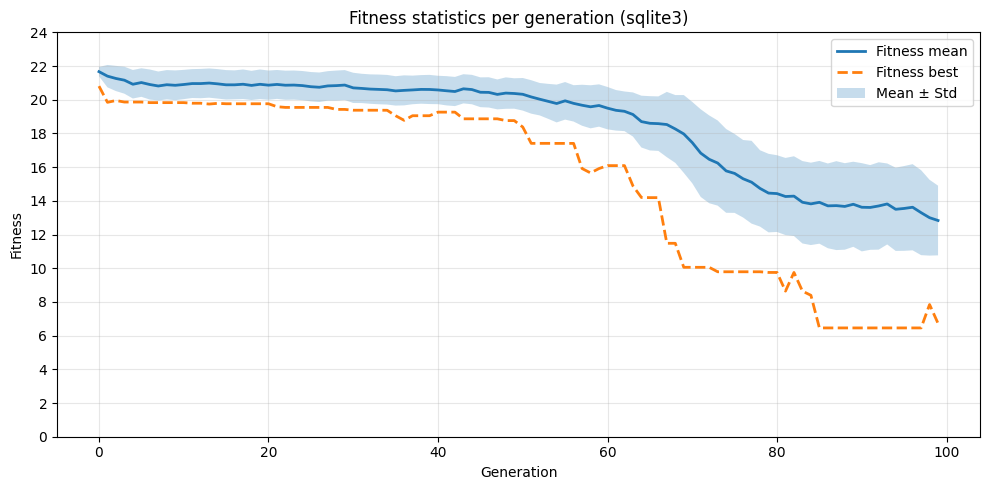

In [14]:
# Convert to NumPy arrays for masking/plotting
gens = np.array(generations, dtype=int)
means_arr = np.array(means, dtype=float)
stds_arr = np.array(stds, dtype=float)
bests_arr = np.array(bests, dtype=float)

# Mask to ignore generations without valid data
mask = ~np.isnan(means_arr)

x = gens[mask]
mean = means_arr[mask]
std = stds_arr[mask]
best = bests_arr[mask]

plt.figure(figsize=(10, 5))

plt.plot(x, mean, label="Fitness mean", linewidth=2)
plt.plot(x, best, "--", label="Fitness best", linewidth=2)
plt.fill_between(x, mean - std, mean + std, alpha=0.25, label="Mean ± Std")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness statistics per generation (sqlite3)")
plt.legend()
plt.yticks(range(0, int(max(mean) + 5), 2))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
